In [6]:
# Some calculation for the LHF coupling and separation across spatial scales.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import glob
import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import geometry as gm
import warnings; warnings.filterwarnings("ignore")

from func_statistics import *

import os

In [7]:
from scipy.stats import linregress

def density_scatter(x,y,xlabel,ylabel, minititle):
    fig = plt.figure(figsize=(8,5))
    
    x,y = x[(~np.isnan(x))&(~np.isnan(y))], y[(~np.isnan(x))&(~np.isnan(y))]
    hb = plt.hexbin(x, y, mincnt=1, gridsize=100, bins='log', cmap='inferno')
    cb = plt.colorbar(hb, label='counts')
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.grid()
    
    lr_out = linregress(x,y)
    print(lr_out[1])
    plt.title(f'r={lr_out[2]:.2f}, s={lr_out[0]:.4f} (pval={lr_out[3]:.2}) ' + minititle)
    ics = np.array([np.min(x), np.max(x)])
    plt.plot(ics,ics*lr_out[0]+lr_out[1],'r')
    
def density_scatter_ax(ax,x,y,xlabel,ylabel, minititle, cmap):
    
    x,y = x[(~np.isnan(x))&(~np.isnan(y))], y[(~np.isnan(x))&(~np.isnan(y))]
    hb = ax.hexbin(x, y, mincnt=1, gridsize=100, bins='log', cmap=cmap)
#    cb = ax.colorbar(hb, label='counts')
    fig = ax.get_figure()
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts', fontsize=14)
    
    ax.set_xlabel(xlabel,fontsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    ax.grid()
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    lr_out = linregress(x,y)
    print(lr_out[1])
    ax.set_title(f'r={lr_out[2]:.2f}, s={lr_out[0]:.4f} ({lr_out[3]:.2})'+minititle, fontsize=15)
    ics = np.array([np.min(x), np.max(x)])
    ax.plot(ics,ics*lr_out[0]+lr_out[1],'r')
    ax.plot(ics, ics, '--k')

In [8]:
# import sea_mask
# if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
#     sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')    
    
    

In [9]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))


wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

lon = ds_hourly['nav_lon'].values
lat = ds_hourly['nav_lat'].values

In [10]:
passalto_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW*passalto*DIR*.nc')
passalto_files = sorted(passalto_files)

ds_cou = xr.open_dataset(passalto_files[0])

In [13]:
rain = ds_hourly['RAINNCV']  # RAINNCV
rain_day = rain.groupby('time_counter.day').sum()
rain_day = rain_day.where(sea_mask_modified, drop=False);

q2 = ds_hourly['RAINNCV']
q2_day = q2.groupby('time_counter.day').mean()
dq2 = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dq2_day_feb.npy')
dq2 = dq2*sea_mask_modified_nan

In [54]:
#rain_total_dom = rain_day.sum(dim=('x', 'y')).values
rain_total_dom = np.nansum(rain_day.values*sea_mask_modified_nan, axis=(1,2))

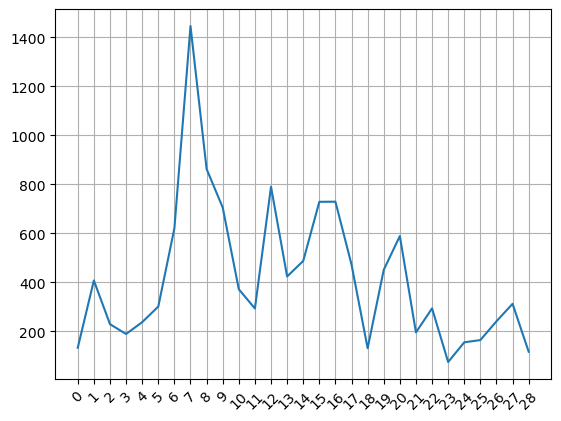

In [55]:
xxx = np.arange(29)
plt.plot(xxx, rain_total_dom)
plt.xticks(xxx, rotation=45)
plt.grid()
plt.show()

In [64]:
## DRAW A TIME SERIES OF RATIO
days = np.arange(29)

rain_1, rain_2, rain_3 = np.zeros(rain_day.shape[0]), np.zeros(rain_day.shape[0]), np.zeros(rain_day.shape[0])

for i in range(rain_day.shape[0]):
    rain_1[i] = np.nanpercentile(rain_day[i], 10)
    rain_2[i] = np.nanpercentile(rain_day[i], 50)
    rain_3[i] = np.nanpercentile(rain_day[i], 100)


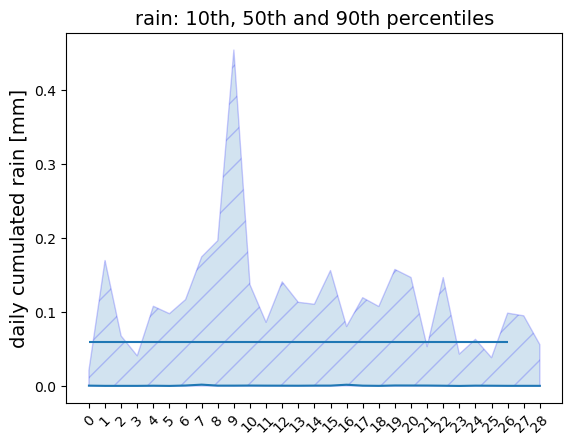

In [67]:
plt.plot(rain_2)
plt.fill_between(days, rain_1, rain_3, alpha=0.2, hatch='/', edgecolor='blue', linewidth=1.)

plt.ylabel('daily cumulated rain [mm]', fontsize=14)
plt.title('rain: 10th, 50th and 100th percentiles', fontsize=14)
plt.xticks(days, rotation=45)

plt.hlines(0.06, xmin=0, xmax=26)

plt.show()



<a list of 6 text.Text objects>

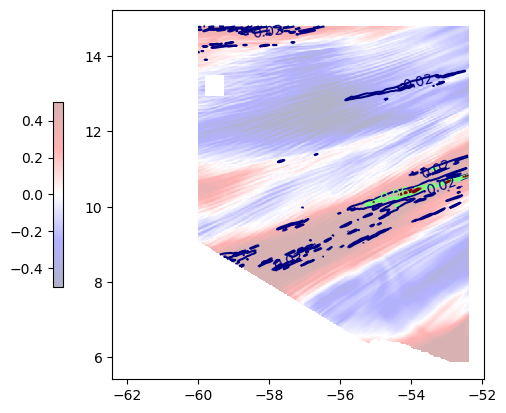

In [12]:
'''fig, ax = plt.subplots(1, 2)

mesh_rain = ax[0].pcolormesh(rain_day[6]*sea_mask_modified_nan)
fig.colorbar(mesh_rain, ax=ax[0], position = 'left', shrink=0.5)

mesh_dq2 = '''

plt.pcolormesh(lon, lat, dq2[6]*1000, cmap='seismic', vmin=-0.5, vmax=0.5, alpha=0.3)
plt.colorbar(location = 'left', shrink=0.5)

cont = plt.contour(lon, lat, rain_day[6], levels=[0.02, 0.06, 0.1], cmap='jet')
plt.clabel(cont, inline=True, fontsize=10)

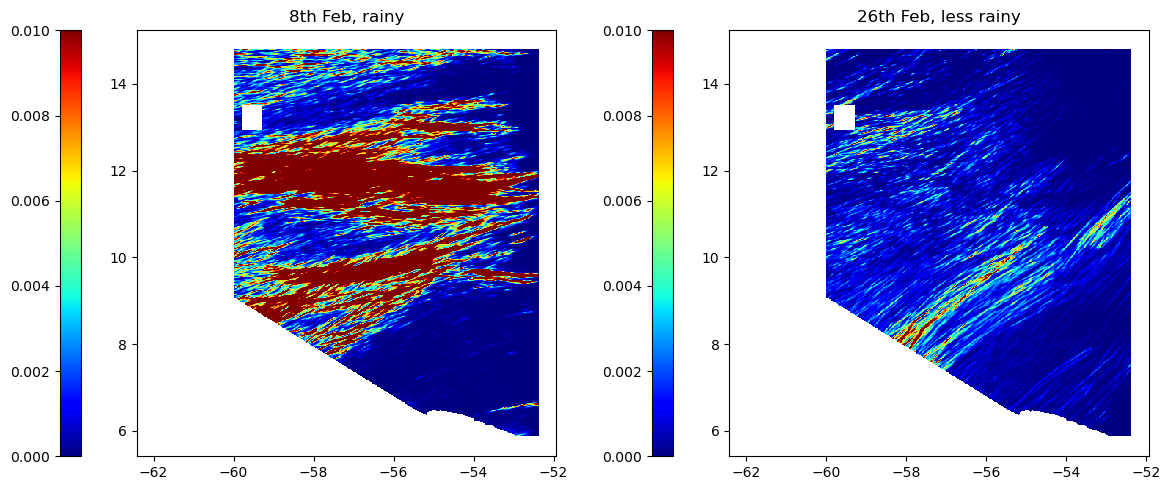

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

rain1 = ax[0].pcolormesh(lon, lat, rain_day[7], cmap='jet', vmin=0., vmax=0.01)
fig.colorbar(rain1, ax=ax[0], location='left')
ax[0].set_title('8th Feb, rainy')

rain2 = ax[1].pcolormesh(lon, lat, rain_day[25], cmap='jet', vmin=0., vmax=0.01)
fig.colorbar(rain2, ax=ax[1], location='left')
ax[1].set_title('26th Feb, less rainy')

plt.tight_layout()

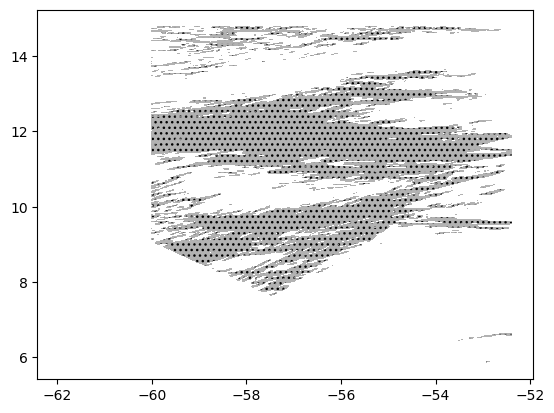

In [76]:
rain_mask = np.zeros_like(rain_day[7])
rain_mask[rain_day[7] > 0.005] = 1

cont_q = plt.contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)

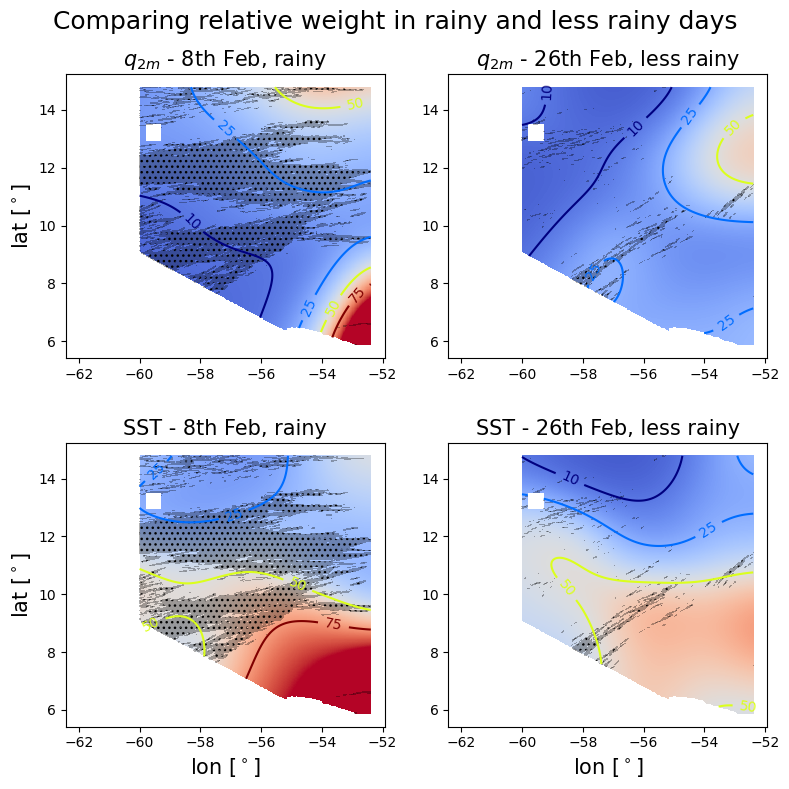

In [78]:
day = int(7)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))  # Create the figure with subplots
ax = ax.flatten()  # Flatten the axis array for easier indexing





##########  FIRST PLOT
x = ((ds_cou['lambda_q'].values[day]**2 * ds_cou['var_qa'].values[day])) / (ds_cou['var_lhf'].values[day])

mesh1 = ax[0].pcolormesh(lon, lat, x * 100, cmap='coolwarm', vmin=0, vmax=100)

cont = ax[0].contour(lon, lat, x * 100, levels=[10., 25., 50., 75], cmap='jet')
ax[0].clabel(cont, inline=True, fontsize=10)


rain_mask = np.zeros_like(rain_day[day])
rain_mask[rain_day[day] > 0.005] = 1

cont_q = ax[0].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)
#ax[0].clabel(cont_q, inline=True, fontsize=10)

ax[0].set_title(r'$q_{2m}$ - 8th Feb, rainy', fontsize=15)
ax[0].set_ylabel('lat [$^\circ$]', fontsize=15)







##########  THIRD PLOT
x = ((ds_cou['lambda_sst'].values[day]**2 * ds_cou['var_sst'].values[day])) / (ds_cou['var_lhf'].values[day])

mesh3 = ax[2].pcolormesh(lon, lat, x * 100, cmap='coolwarm', vmin=0, vmax=100)

cont = ax[2].contour(lon, lat, x * 100, levels=[10., 25., 50., 75], cmap='jet')
ax[2].clabel(cont, inline=True, fontsize=10)

ax[2].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)

ax[2].set_title('SST - 8th Feb, rainy', fontsize=15)
ax[2].set_xlabel('lon [$^\circ$]', fontsize=15)
ax[2].set_ylabel('lat [$^\circ$]', fontsize=15)







day = int(25)

##########  SECOND PLOT
x = ((ds_cou['lambda_q'].values[day]**2 * ds_cou['var_qa'].values[day])) / (ds_cou['var_lhf'].values[day])

mesh2 = ax[1].pcolormesh(lon, lat, x * 100, cmap='coolwarm', vmin=0, vmax=100)

# Add the colorbar to this plot only, but match size with the other subplots
#cbar = fig.colorbar(mesh2, location='bottom', shrink=0.7)
#cbar.set_label('%', fontsize=15)

cont = ax[1].contour(lon, lat, x * 100, levels=[10., 25., 50., 75], cmap='jet')
ax[1].clabel(cont, inline=True, fontsize=10)


rain_mask = np.zeros_like(rain_day[day])
rain_mask[rain_day[day] > 0.005] = 1

cont_q = ax[1].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)
#ax[1].clabel(cont_q, inline=True, fontsize=10)

ax[1].set_title('$q_{2m}$ - 26th Feb, less rainy', fontsize=15)








##########  FOURTH PLOT
x = ((ds_cou['lambda_sst'].values[day]**2 * ds_cou['var_sst'].values[day])) / (ds_cou['var_lhf'].values[day])

mesh4 = ax[3].pcolormesh(lon, lat, x * 100, cmap='coolwarm', vmin=0, vmax=100)

cont = ax[3].contour(lon, lat, x * 100, levels=[10., 25., 50., 75], cmap='jet')
ax[3].clabel(cont, inline=True, fontsize=10)

ax[3].set_title('SST - 26th Feb, less rainy', fontsize=15)
ax[3].set_xlabel('lon [$^\circ$]', fontsize=15)

ax[3].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)


# Apply the title and layout
fig.suptitle('Comparing relative weight in rainy and less rainy days', fontsize=18)
plt.tight_layout()

# Adjust the layout so that all subplots have the same size
plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Fine-tune spacing between subplots



In [82]:
sst_terms_cou     = (ds_cou['lambda_sst'].values**2*ds_cou['var_sst'].values + 2*ds_cou['lambda_sst'].values*(ds_cou['lambda_U'].values*ds_cou['covar_U_sst'].values + ds_cou['lambda_q'].values*ds_cou['covar_q_sst'].values))
non_sst_terms_cou = (ds_cou['lambda_U'].values**2*ds_cou['var_U'].values + ds_cou['lambda_q'].values**2*ds_cou['var_qa'].values + 2*ds_cou['lambda_q'].values*ds_cou['lambda_U'].values*ds_cou['covar_U_q'].values)


#sst_terms_for     = (ds_for['lambda_sst'].values**2*ds_for['var_sst'].values + 2*ds_for['lambda_sst'].values*(ds_for['lambda_U'].values*ds_for['covar_U_sst'].values + ds_for['lambda_q'].values*ds_for['covar_q_sst'].values))
#non_sst_terms_for = (ds_for['lambda_U'].values**2*ds_for['var_U'].values + ds_for['lambda_q'].values**2*ds_for['var_qa'].values + 2*ds_for['lambda_q'].values*ds_for['lambda_U'].values*ds_for['covar_q_U'].values)


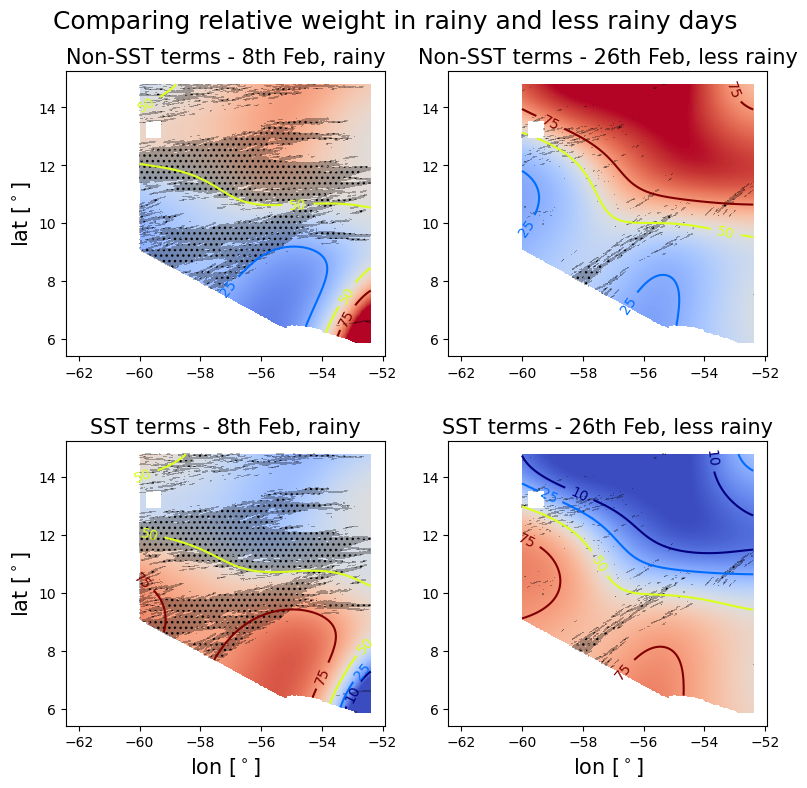

In [83]:
day = int(7)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))  # Create the figure with subplots
ax = ax.flatten()  # Flatten the axis array for easier indexing





##########  FIRST PLOT
x = non_sst_terms_cou[day] / (ds_cou['var_lhf'].values[day])

mesh1 = ax[0].pcolormesh(lon, lat, x * 100, cmap='coolwarm', vmin=0, vmax=100)

cont = ax[0].contour(lon, lat, x * 100, levels=[10., 25., 50., 75], cmap='jet')
ax[0].clabel(cont, inline=True, fontsize=10)


rain_mask = np.zeros_like(rain_day[day])
rain_mask[rain_day[day] > 0.005] = 1

cont_q = ax[0].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)
#ax[0].clabel(cont_q, inline=True, fontsize=10)

ax[0].set_title(r'Non-SST terms - 8th Feb, rainy', fontsize=15)
ax[0].set_ylabel('lat [$^\circ$]', fontsize=15)







##########  THIRD PLOT
x = sst_terms_cou[day] / (ds_cou['var_lhf'].values[day])

mesh3 = ax[2].pcolormesh(lon, lat, x * 100, cmap='coolwarm', vmin=0, vmax=100)

cont = ax[2].contour(lon, lat, x * 100, levels=[10., 25., 50., 75], cmap='jet')
ax[2].clabel(cont, inline=True, fontsize=10)

ax[2].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)

ax[2].set_title('SST terms - 8th Feb, rainy', fontsize=15)
ax[2].set_xlabel('lon [$^\circ$]', fontsize=15)
ax[2].set_ylabel('lat [$^\circ$]', fontsize=15)







day = int(25)

##########  SECOND PLOT
x = non_sst_terms_cou[day] / (ds_cou['var_lhf'].values[day])

mesh2 = ax[1].pcolormesh(lon, lat, x * 100, cmap='coolwarm', vmin=0, vmax=100)

# Add the colorbar to this plot only, but match size with the other subplots
#cbar = fig.colorbar(mesh2, location='bottom', shrink=0.7)
#cbar.set_label('%', fontsize=15)

cont = ax[1].contour(lon, lat, x * 100, levels=[10., 25., 50., 75], cmap='jet')
ax[1].clabel(cont, inline=True, fontsize=10)


rain_mask = np.zeros_like(rain_day[day])
rain_mask[rain_day[day] > 0.005] = 1

cont_q = ax[1].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)
#ax[1].clabel(cont_q, inline=True, fontsize=10)

ax[1].set_title('Non-SST terms - 26th Feb, less rainy', fontsize=15)








##########  FOURTH PLOT
x = sst_terms_cou[day] / (ds_cou['var_lhf'].values[day])

mesh4 = ax[3].pcolormesh(lon, lat, x * 100, cmap='coolwarm', vmin=0, vmax=100)

cont = ax[3].contour(lon, lat, x * 100, levels=[10., 25., 50., 75], cmap='jet')
ax[3].clabel(cont, inline=True, fontsize=10)

ax[3].set_title('SST terms - 26th Feb, less rainy', fontsize=15)
ax[3].set_xlabel('lon [$^\circ$]', fontsize=15)

ax[3].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)


# Apply the title and layout
fig.suptitle('Comparing relative weight in rainy and less rainy days', fontsize=18)
plt.tight_layout()

# Adjust the layout so that all subplots have the same size
plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Fine-tune spacing between subplots



### what if I distinguish between q_terms and non_q_terms?

In [11]:
q_terms_cou     = (ds_cou['lambda_q'].values**2*ds_cou['var_qa'].values + 2*ds_cou['lambda_q'].values*(ds_cou['lambda_U'].values*ds_cou['covar_U_q'].values + ds_cou['lambda_sst'].values*ds_cou['covar_q_sst'].values))
non_q_terms_cou = (ds_cou['lambda_U'].values**2*ds_cou['var_U'].values + ds_cou['lambda_sst'].values**2*ds_cou['var_sst'].values + 2*ds_cou['lambda_sst'].values*ds_cou['lambda_U'].values*ds_cou['covar_U_sst'].values)


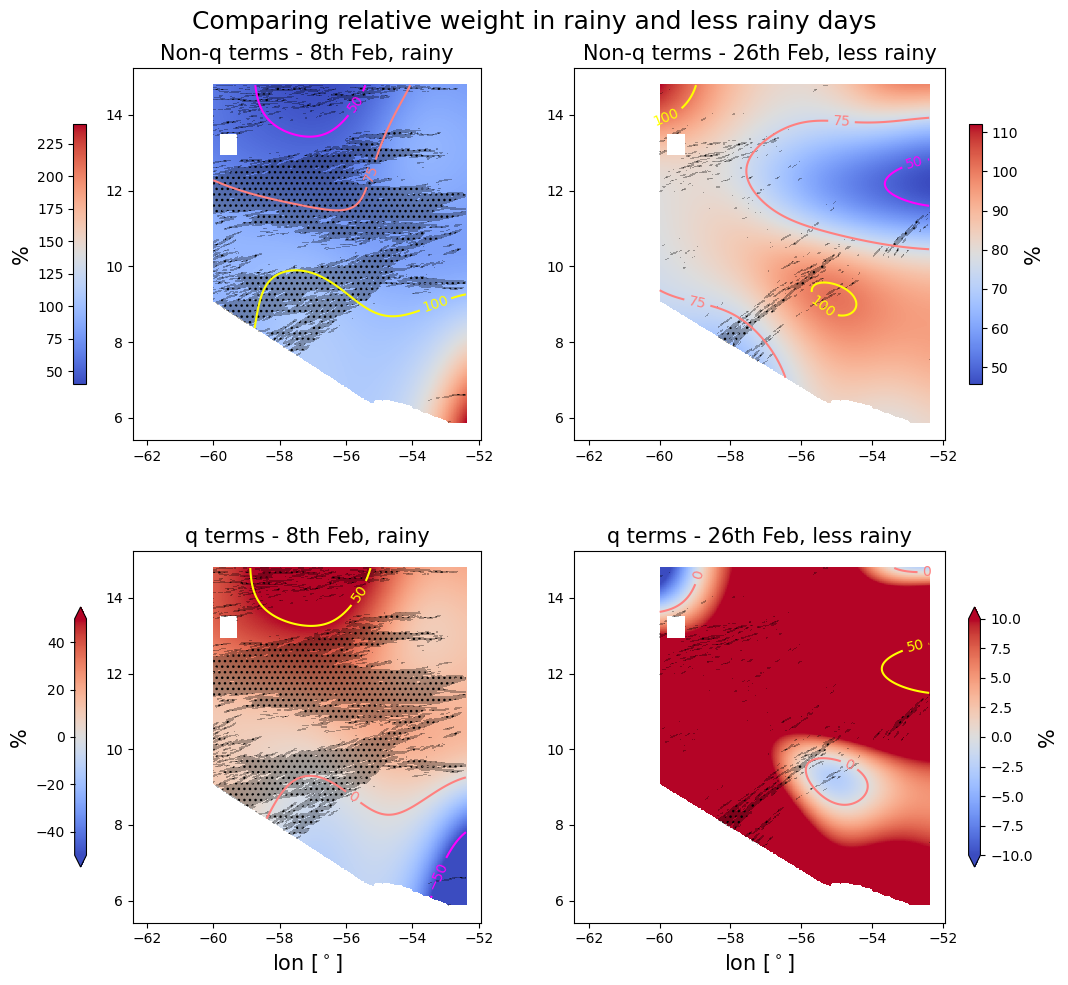

In [27]:
day = int(7)

fig, ax = plt.subplots(2, 2, figsize=(11, 10))# Create the figure with subplots
ax = ax.flatten()  # Flatten the axis array for easier indexing





##########  FIRST PLOT
x = non_q_terms_cou[day] / (ds_cou['var_lhf'].values[day])

mesh1 = ax[0].pcolormesh(lon, lat, x * 100, cmap='coolwarm') #, vmin=0, vmax=100)

cont = ax[0].contour(lon, lat, x * 100, levels=[50., 75., 100.], cmap='spring')
ax[0].clabel(cont, inline=True, fontsize=10)


rain_mask = np.zeros_like(rain_day[day])
rain_mask[rain_day[day] > 0.005] = 1

cont_q = ax[0].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)
#ax[0].clabel(cont_q, inline=True, fontsize=10)

ax[0].set_title(r'Non-q terms - 8th Feb, rainy', fontsize=15)
# ax[0].set_ylabel('lat [$^\circ$]', fontsize=15)

cbar = fig.colorbar(mesh1, ax=ax[0], location='left', shrink=0.7)
cbar.set_label('%', fontsize=15)





##########  THIRD PLOT
x = q_terms_cou[day] / (ds_cou['var_lhf'].values[day])

mesh3 = ax[2].pcolormesh(lon, lat, x * 100, cmap='coolwarm', vmin=-50, vmax=50)

cont = ax[2].contour(lon, lat, x * 100, levels=[-50., 0., 50.], cmap='spring')
ax[2].clabel(cont, inline=True, fontsize=10)

ax[2].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)

ax[2].set_title('q terms - 8th Feb, rainy', fontsize=15)
ax[2].set_xlabel('lon [$^\circ$]', fontsize=15)
# ax[2].set_ylabel('lat [$^\circ$]', fontsize=15)

cbar = fig.colorbar(mesh3, ax=ax[2], location='left', shrink=0.7, extend='both')
cbar.set_label('%', fontsize=15)





day = int(25)

##########  SECOND PLOT
x = non_q_terms_cou[day] / (ds_cou['var_lhf'].values[day])

mesh2 = ax[1].pcolormesh(lon, lat, x * 100, cmap='coolwarm') #, vmin=0, vmax=100)

cont = ax[1].contour(lon, lat, x * 100, levels=[50., 75., 100.], cmap='spring')
ax[1].clabel(cont, inline=True, fontsize=10)


rain_mask = np.zeros_like(rain_day[day])
rain_mask[rain_day[day] > 0.005] = 1

cont_q = ax[1].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)
#ax[1].clabel(cont_q, inline=True, fontsize=10)

ax[1].set_title('Non-q terms - 26th Feb, less rainy', fontsize=15)


# Add the colorbar to this plot only, but match size with the other subplots
cbar = fig.colorbar(mesh2, ax=ax[1], location='right', shrink=0.7)
cbar.set_label('%', fontsize=15)





##########  FOURTH PLOT
x = q_terms_cou[day] / (ds_cou['var_lhf'].values[day])

mesh4 = ax[3].pcolormesh(lon, lat, x * 100, cmap='coolwarm', vmin=-10, vmax=10)

cont = ax[3].contour(lon, lat, x * 100, levels=[-50., 0., 50.], cmap='spring')
ax[3].clabel(cont, inline=True, fontsize=10)

ax[3].set_title('q terms - 26th Feb, less rainy', fontsize=15)
ax[3].set_xlabel('lon [$^\circ$]', fontsize=15)

ax[3].contourf(lon, lat, rain_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.3)

cbar = fig.colorbar(mesh4, ax=ax[3], location='right', shrink=0.7, extend='both')
cbar.set_label('%', fontsize=15)

# Apply the title and layout
fig.suptitle('Comparing relative weight in rainy and less rainy days', fontsize=18)
plt.tight_layout()

# Adjust the layout so that all subplots have the same size
plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Fine-tune spacing between subplots



In [ ]:
passabanda_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW*band-pass*DIR*_all.nc')
passabanda_files = sorted(passabanda_files)
